In [1]:
import time
import xml.etree.ElementTree as ET
import os
import pandas as pd
from map import Map
from routes import RoutesFactoryOx, RoutesFactorySumo
from vehicles import VehicleFactory, VehicleType
from sumo_files import save_net_file, save_rou_file, save_config_file, run_sumo_simulation, get_emissions, get_statistics
from algoritmos import all_people_distances, algoritmo_voraz, algoritmo_voraz_q_prioridades, algoritmo_genetico

In [2]:
def create_map(value, type='place_name'):
    mapa = Map(value, arg = "place_name")
    return mapa

def save_map(file_name, mapa):
    graphm_file = f"{file_name}.graphml.xml"
    osm_file = f"{file_name}.osm.xml"
    mapa.save_map_osm(osm_file)
    mapa.save_map_graphml(graphm_file)
    return graphm_file, osm_file

def create_factory_ox(G, n_rutas, min_nodes_route, seed):
    factory = RoutesFactoryOx(G, n_rutas, min_nodes_route, seed)
    factory.create_routes()
    return factory

#seed = 10
#min_nodes_route = 6
#  # list of routes objects
#factory.get_routes_length()

def create_factory_sumo(sumo_file_net, factory_ox):
    ox_routes = factory_ox.routes
    factory_sumo = RoutesFactorySumo()
    factory_sumo.create_routes(sumo_file_net, ox_routes)
    return factory_sumo
#sumo_file_net = 'testBenito.net.xml'
#factory_sumo.get_routes_length()

#for the moment the program has only 3
def create_vehicle_types():
    vehicle_types=[]
    
    vehicle_type1 = VehicleType()
    vehicle_type1.set_attribute("id", "type1")
    vehicle_type1.set_attribute("vClass", "passenger")
    vehicle_type1.set_attribute("guiShape", "passenger/wagon")
    vehicle_type1.set_attribute("personCapacity", 5)
    vehicle_types.append(vehicle_type1)
    
    vehicle_type2 = VehicleType()
    vehicle_type2.set_attribute("id", "type2")
    vehicle_type2.set_attribute("vClass", "passenger")
    vehicle_type2.set_attribute("guiShape", "passenger/sedan")
    vehicle_type2.set_attribute("personCapacity", 5)
    vehicle_types.append(vehicle_type2)
    
    vehicle_type3 = VehicleType()
    vehicle_type3.set_attribute("id", "type3")
    vehicle_type3.set_attribute("vClass", "passenger")
    vehicle_type3.set_attribute("guiShape", "passenger/hatchback")
    vehicle_type3.set_attribute("personCapacity", 5)
    vehicle_types.append(vehicle_type3)

    return vehicle_types
    
def create_vehicle_factory(G, factory_sumo, vehicle_types, sharing_type, p_ignore, p_sharing, distribution, scale):
    routes = factory_sumo.routes
    vehicle_factory = VehicleFactory(G, vehicle_types, sharing_type, p_ignore, p_sharing, distribution, scale)
    vehicle_factory.create_vehicles(routes)
    return vehicle_factory
    
def update_destinations(destinations, factory_ox, veh_factory):
    veh_not_sharing = veh_factory.veh_not_sharing
    factory_ox.update_destinations(destinations, veh_not_sharing)
    return True

In [3]:
def create_map_data(place_name, file_name):
    mapa = create_map(place_name, type='place_name')
    print("---mapa creado----")
    G = mapa.graph
    osm_file = mapa.save_map_osm(file_name)
    print(f"---Archivo {osm_file} creado----")
    graphm_file = mapa.save_map_graphml(file_name)
    print(f"---Archivo {graphm_file} creado----")
    return G, osm_file

In [4]:
def create_factories(G, n_rutas, min_nodes_route, sumo_file_net, seed):
    print(f"Total de rutas a crear: {n_rutas}")
    start_time = time.time()
    factory_ox = create_factory_ox(G, n_rutas, min_nodes_route, seed)
    print(f"---Fábrica ox creada ----")
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Para la creación de la fábrica ox tomo: {runtime}")
    
    start_time = time.time()
    factory_sumo = create_factory_sumo(sumo_file_net, factory_ox)
    print(f"---Fábrica sumo creada ----")
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Para la creación de la fábrica sumo tomo: {runtime}")
    print(f"Total de rutas validas que se crearon: {factory_sumo.get_routes_length()}")
    return factory_ox, factory_sumo
    

In [15]:
def vehicle_factory_and_distances(G, factory_sumo, vehicle_types, sharing_type, p_ignore, p_sharing, distribution, scale, destinations, factory_ox):
    print(f"---Tipos de vehiculos creados ----")
    veh_factory = create_vehicle_factory(G, factory_sumo, vehicle_types, sharing_type, p_ignore, p_sharing, distribution, scale)
    print(f"--- Fábrica de vehiculos creada ----")
    print("vehiculos ignorados: ",len(veh_factory.veh_ignore))
    print("vehiculos que quieren carro: ",len(veh_factory.veh_not_sharing))
    print("vehiculos que comparten carro: ", len(veh_factory.veh_sharing))

    print(f"--- Se actualizaron los destinos ----")
    actualizar_destinos = update_destinations(destinations, factory_ox, veh_factory)
    
    print("-----calculo de distancias----")
    start_time = time.time()
    q, dict_distances = all_people_distances(veh_factory)
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Calculo de distancias: {runtime}s")
    return veh_factory, q, dict_distances

In [6]:
##########Algoritmos#########
def ejecutar_algoritmos(veh_factory, q, dict_distances):
    print("----EMPIEZAN ALGORITMOS---------")
    start_time = time.time()
    print('\n----Empieza algoritmo_voraz_q_prioridades-----')
    veh_fact_voraz_q, total_people_walk_prioridades, final_vehicles_prioridades = algoritmo_voraz_q_prioridades(veh_factory, q)
    print(total_people_walk_prioridades)
    end_time = time.time()
    runtime_vq = end_time - start_time
    print(f"Algoritmo voraz con prioridades corrio en: {runtime_vq}s")
    
    start_time = time.time()
    print('\n----Empieza algoritmo_voraz-----')
    veh_fact_voraz, total_people_walk, final_vehicles = algoritmo_voraz(veh_factory, dict_distances)
    print(total_people_walk)
    end_time = time.time()
    runtime_v = end_time - start_time
    print(f"Algoritmo voraz corrio en: {runtime_v}s")
    return runtime_vq, veh_fact_voraz_q, total_people_walk_prioridades, final_vehicles_prioridades, runtime_v, veh_fact_voraz, total_people_walk, final_vehicles

In [7]:
place_name = "Benito Juárez, Mexico City, Mexico"
file_name = "simulaciones/Benito_Juarez"
G, osm_file = create_map_data(place_name, file_name)
sumo_file_net = save_net_file(osm_file)
print(f"---Archivo {sumo_file_net} creado----")
n_rutas = 2500
min_nodes_route = 6
seed = 10
factory_ox, factory_sumo = create_factories(G, n_rutas, min_nodes_route, sumo_file_net, seed)

---mapa creado----


C:\Users\mgutie91\AppData\Local\Programs\Python\Python310\venvs\tesis\lib\site-packages\osmnx\osm_xml.py:280: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['False' 'False' 'True' ... 'True' 'False' 'False']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  gdf_edges.loc[:, "oneway"] = gdf_edges["oneway"].astype(str)


---Archivo simulaciones/Benito_Juarez.osm.xml creado----
---Archivo simulaciones/Benito_Juarez.graphml.xml creado----
---Archivo simulaciones/Benito_Juarez.net.xml creado----
Total de rutas a crear: 2500
---Fábrica ox creada ----
Para la creación de la fábrica ox tomo: 66.50075697898865
Log: Error en la creacion de la ruta sumo
Log: Error en la creacion de la ruta sumo
Log: Error en la creacion de la ruta sumo
---Fábrica sumo creada ----
Para la creación de la fábrica sumo tomo: 42.44705939292908
Total de rutas validas que se crearon: 2127


In [8]:
df = pd.DataFrame(columns=['p_sharing', 'run', 'veh_ign', 'veh_not_sh', 'veh_sh', 'algorithm', 
                           'distance', 'runtime', 'emiss_f', 'stats_f', 'total_co2', 'total_co', 'total_hc', 'total_nox',
                          'count', 'routeLength', 'speed', 'duration', 'waitingTime', 'timeLoss', 'departDelay',
                           'departDelayWaiting', 'totalTravelTime', 'totalDepartDelay'])

vehicle_types = create_vehicle_types()
sharing_type = 'random'
p_ignore = 0.20
distribution = None
scale = None
destinations = [["metro Xola", (-99.137785,19.395184)],
            ["metro Villa de Cortes", (-99.138983,19.387581)],
            ["metro Eugenia", (-99.156863,19.386139)],
            ["metro División del Norte", (-99.159502, 19.379105)],
            ["metro Portales", (-99.141644,19.369849)],
            ["metro Mixcoac", (-99.186966, 19.376015)],
            ["metro Insurgentes Sur", (-99.178806, 19.373718)],
            ]

sharing_ids = ['p2', 'p4', 'p6', 'p8', 'p9']
p_sharings = [0.2, 0.4, 0.6, 0.8, 0.9]
ejecuciones = 5
flag_config_orig = True
for idx, p_sharing in enumerate(p_sharings):
    for idx2 in range(ejecuciones):
        veh_factory, q, dict_distances = vehicle_factory_and_distances(G, factory_sumo, vehicle_types, sharing_type, p_ignore, p_sharing, distribution, scale, destinations, factory_ox)
        runtime_vq, veh_fact_voraz_q, total_people_walk_prioridades, final_vehicles_prioridades, runtime_v, veh_fact_voraz, total_people_walk, final_vehicles=ejecutar_algoritmos(veh_factory, q, dict_distances)
        id_v = f"a_voraz_{sharing_ids[idx]}_r{idx2+1}"
        id_vq = f"a_vq_{sharing_ids[idx]}_r{idx2+1}"
        rou_orig = "simulaciones/Benito_Juarez.rou.xml"
        rou_sh_v = f"simulaciones/alg_voraz/{sharing_ids[idx]}/run{idx2+1}/{id_v}_Benito_Juarez_sh.rou.xml" 
        rou_sh_vq = f"simulaciones/alg_vorazq/{sharing_ids[idx]}/run{idx2+1}/{id_vq}_Benito_Juarez_sh.rou.xml"
        
        print("-----Creando archivos rutas para SUMO------")
        save_rou_file(veh_fact_voraz, rou_orig, rou_sh_v)
        save_rou_file(veh_fact_voraz_q, rou_orig, rou_sh_vq)

        if flag_config_orig:
            print("-----Creando archivos configuraciones para SUMO orig------")
            config_file_orig = "simulaciones/Benito_Juarez.sumocfg"
            sharing_status = False
            config_file_orig = save_config_file('', config_file_orig, rou_orig, sumo_file_net, sharing_status)
            run_sumo_simulation(config_file_orig)
            flag_config_orig = False

        print("-----Creando archivos configuraciones para SUMO------")
        sharing_status = True
        config_sh_v = f"simulaciones/alg_voraz/{sharing_ids[idx]}/run{idx2+1}/{id_v}_Benito_Juarez_sh.sumocfg"
        config_sh_vq = f"simulaciones/alg_vorazq/{sharing_ids[idx]}/run{idx2+1}/{id_vq}_Benito_Juarez_sh.sumocfg"
        config_file_v = save_config_file(id_v, config_sh_v, rou_sh_v, sumo_file_net, sharing_status)
        config_file_vq = save_config_file(id_vq, config_sh_vq, rou_sh_vq, sumo_file_net, sharing_status)
        emiss_file_v = f"simulaciones/alg_voraz/{sharing_ids[idx]}/run{idx2+1}/{id_v}_emissions_sh.xml"
        stats_file_v = f"simulaciones/alg_voraz/{sharing_ids[idx]}/run{idx2+1}/{id_v}_statistics_sh.xml"
        emiss_file_vq = f"simulaciones/alg_vorazq/{sharing_ids[idx]}/run{idx2+1}/{id_vq}_emissions_sh.xml"
        stats_file_vq = f"simulaciones/alg_vorazq/{sharing_ids[idx]}/run{idx2+1}/{id_vq}_statistics_sh.xml"
        
        print("-----Corriendo simulaciones------")
        run_sumo_simulation(config_file_v)
        run_sumo_simulation(config_file_vq)

        print("----Obteniendo emisiones y estadisticas----")
        emiss_v = get_emissions(emiss_file_v)
        emiss_vq = get_emissions(emiss_file_vq)
        stats_v = get_statistics(stats_file_v)
        stats_vq = get_statistics(stats_file_vq)
        
        new_row= pd.DataFrame({'p_sharing':p_sharing, 'run':idx2+1, 'veh_ign':len(veh_factory.veh_ignore), 
                               'veh_not_sh':len(veh_factory.veh_not_sharing), 'veh_sh':len(veh_factory.veh_sharing), 
                               'algorithm':['voraz'], 'distance':total_people_walk, 'runtime':runtime_v, 
                               'emiss_f':emiss_file_v, 'stats_f':stats_file_v, 'total_co2':emiss_v['total_co2'], 
                               'total_co':emiss_v['total_co'], 'total_hc':emiss_v['total_hc'], 'total_nox':emiss_v['total_nox'],
                          'count':stats_v['count'], 'routeLength':stats_v['routeLength'], 'speed':stats_v['speed'], 
                               'duration':stats_v['duration'], 'waitingTime':stats_v['waitingTime'], 'timeLoss':stats_v['timeLoss'], 
                               'departDelay':stats_v['departDelay'], 'departDelayWaiting':stats_v['departDelayWaiting'], 
                               'totalTravelTime':stats_v['totalTravelTime'], 'totalDepartDelay':stats_v['totalDepartDelay']})
        df = pd.concat([df, new_row], ignore_index=True)
        
        new_row =  pd.DataFrame({'p_sharing':p_sharing, 'run':[idx2+1], 'veh_ign':len(veh_factory.veh_ignore), 
                                 'veh_not_sh':len(veh_factory.veh_not_sharing), 'veh_sh':len(veh_factory.veh_sharing), 
                                 'algorithm':'voraz_q', 'distance':total_people_walk_prioridades, 'runtime':runtime_vq, 
                                 'emiss_f':emiss_file_vq, 'stats_f':stats_file_vq, 'total_co2':emiss_vq['total_co2'], 
                               'total_co':emiss_vq['total_co'], 'total_hc':emiss_vq['total_hc'], 'total_nox':emiss_vq['total_nox'],
                          'count':stats_vq['count'], 'routeLength':stats_vq['routeLength'], 'speed':stats_vq['speed'], 
                               'duration':stats_vq['duration'], 'waitingTime':stats_vq['waitingTime'], 'timeLoss':stats_vq['timeLoss'], 
                               'departDelay':stats_vq['departDelay'], 'departDelayWaiting':stats_vq['departDelayWaiting'], 
                               'totalTravelTime':stats_vq['totalTravelTime'], 'totalDepartDelay':stats_vq['totalDepartDelay']})
        df = pd.concat([df, new_row], ignore_index=True)
df.to_csv('vehicles_data.csv', index=False)

---Tipos de vehiculos creados ----
--- Fábrica de vehiculos creada ----
vehiculos ignorados:  425
vehiculos que quieren carro:  344
vehiculos que comparten carro:  1358
--- Se actualizaron los destinos ----
-----calculo de distancias----
Ejecutando distancias con cpus: 12.0
El numero de combinaciones es:  467152
Calculo de distancias: 30.88735055923462s
----EMPIEZAN ALGORITMOS---------

----Empieza algoritmo_voraz_q_prioridades-----
Obteniendo distancia total
86255.16531491462
Algoritmo voraz con prioridades corrio en: 0.5869450569152832s

----Empieza algoritmo_voraz-----
86385.1884926256
Algoritmo voraz corrio en: 0.7163207530975342s
-----Creando archivos rutas para SUMO------
-----Creando archivos configuraciones para SUMO orig------
-----Creando archivos configuraciones para SUMO------
-----Corriendo simulaciones------
----Obteniendo emisiones y estadisticas----


C:\Users\mgutie91\AppData\Local\Temp\ipykernel_122196\1759940257.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


---Tipos de vehiculos creados ----
--- Fábrica de vehiculos creada ----
vehiculos ignorados:  425
vehiculos que quieren carro:  351
vehiculos que comparten carro:  1351
--- Se actualizaron los destinos ----
-----calculo de distancias----
Ejecutando distancias con cpus: 12.0
El numero de combinaciones es:  474201
Calculo de distancias: 33.81035804748535s
----EMPIEZAN ALGORITMOS---------

----Empieza algoritmo_voraz_q_prioridades-----
Obteniendo distancia total
90654.11163055187
Algoritmo voraz con prioridades corrio en: 0.5835034847259521s

----Empieza algoritmo_voraz-----
91649.67583011667
Algoritmo voraz corrio en: 0.6960127353668213s
-----Creando archivos rutas para SUMO------
-----Creando archivos configuraciones para SUMO------
-----Corriendo simulaciones------
----Obteniendo emisiones y estadisticas----
---Tipos de vehiculos creados ----
--- Fábrica de vehiculos creada ----
vehiculos ignorados:  425
vehiculos que quieren carro:  361
vehiculos que comparten carro:  1341
--- Se actu

In [11]:
emiss_file_orig = 'simulaciones/emissions.xml'
statistics_file_orig = 'simulaciones/statistics.xml'
stats_orig = get_statistics(statistics_file_orig)
emiss_orig = get_emissions(emiss_file_orig)
print(stats_orig)
print(emiss_orig)

{'count': 2127, 'routeLength': 3578.53, 'speed': 6.93, 'duration': 610.49, 'waitingTime': 269.88, 'timeLoss': 390.82, 'departDelay': 0.91, 'departDelayWaiting': -1.0, 'totalTravelTime': 1298515.0, 'totalDepartDelay': 1939.0}
{'total_co2': 4195808609.9830093, 'total_co': 142675131.11053744, 'total_hc': 746651.8600100451, 'total_nox': 1799717.1599791804}


In [14]:
emiss_orig

{'total_co2': 278596946.2600064,
 'total_co': 7936669.880002001,
 'total_hc': 42576.169999998056,
 'total_nox': 117563.63999993696}

In [10]:
df.to_csv('vehicles_data.csv', index=False)

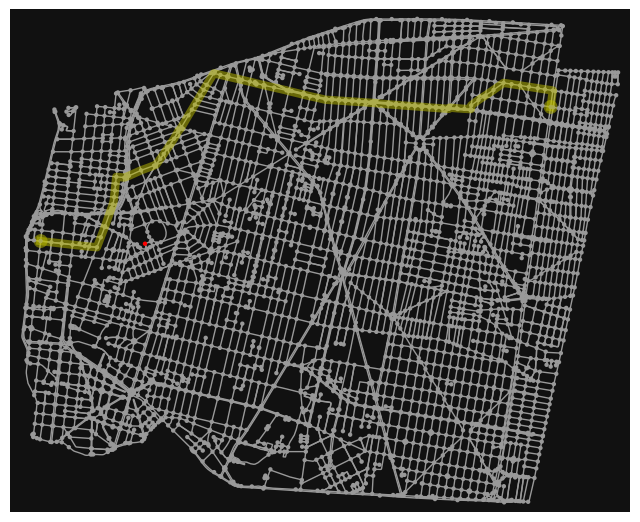

In [105]:
# Define other nodes to highlight
node_s = sharing_not[0].get_attribute('route').ox_route.route[0]
other_nodes = [node_s]  # Replace with actual node IDs if they exist in the graph
# 275420032
route = sharing[0].get_attribute('route').ox_route.route
# Get the position of the nodes to highlight
highlight_nodes = other_nodes
node_colors = ['r' if node in highlight_nodes else '#999999' for node in G.nodes()]

# Plot the graph with the route and highlighted nodes
fig, ax = ox.plot_graph(G, node_color=node_colors, node_size=10, node_zorder=2, show=False, close=False)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, route_color='y', node_size=0, ax=ax)

plt.show()

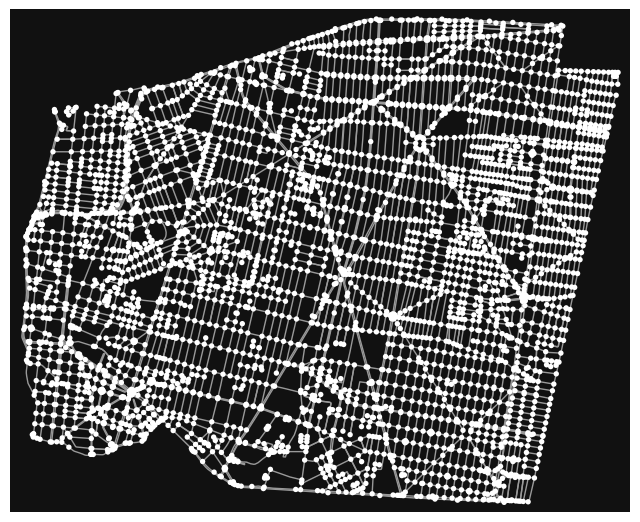

In [12]:
import osmnx as ox
fig, ax = ox.plot_graph(G)